In [1]:
import scipy, time, random, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import sklearn.metrics




# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.data_parser import *
from common.misc import *
import companies_data_preprocessor
from common.model_trainer import ModelTrainer

In [2]:
params = {
    "n_neighbors" : list(range(3,50)), 
    "weights" : ["uniform", "distance"],
    "p" : [1,2]}

#df_list = parse_companies()
#df = pd.concat(df_list)
df = parse_companies(5)#.sample(100)
raw_data, labels = companies_data_preprocessor.preprocess(df)

In [3]:

def plot_params(data, labels, fileName="no name", title="no title"):
    # Splitting
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1)

    modeltrainer = ModelTrainer(
        KNeighborsClassifier, 
        params, 
        x_train, y_train, x_test, y_test, 
        companies_data_preprocessor.calculate_score, 
        thread_cnt=8
        )

    modeltrainer.train()
    #modeltrainer.save_result("out/knn_params.csv")
    df = modeltrainer.result

    uniform_p1 = df.loc[(df['weights'] == "uniform") & (df['p'] == 1)]
    uniform_p2 = df.loc[(df['weights'] == "uniform") & (df['p'] == 2)]
    distance_p1 = df.loc[(df['weights'] == "distance") & (df['p'] == 1)]
    distance_p2 = df.loc[(df['weights'] == "distance") & (df['p'] == 2)]

    plt.plot(uniform_p1["n_neighbors"], uniform_p1["score"], label="uniform")
    #plt.plot(uniform_p2["n_neighbors"], uniform_p2["score"], label="uniform, p=2")
    plt.plot(distance_p1["n_neighbors"], distance_p1["score"], label="distance, p=1")
    plt.plot(distance_p2["n_neighbors"], distance_p2["score"], label="distance, p=2")
    plt.legend()
    plt.title(title)
    plt.ylim(-0.5, 1)
    plt.savefig("out/" + fileName)
    #plt.show()
    return modeltrainer

## Simple Imputation with 0

Finished evaluation
Best parameteters found with: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}
score= 0.23062953995157384
Total evaluation time = 35.24s
Finished evaluation
Best parameteters found with: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}
score= 0.30387409200968524
Total evaluation time = 54.19s
Finished evaluation
Best parameteters found with: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}
score= 0.2917675544794189
Total evaluation time = 20.64s
Finished evaluation
Best parameteters found with: {'n_neighbors': 32, 'weights': 'uniform', 'p': 2}
score= 0.2857142857142857
Total evaluation time = 23.70s


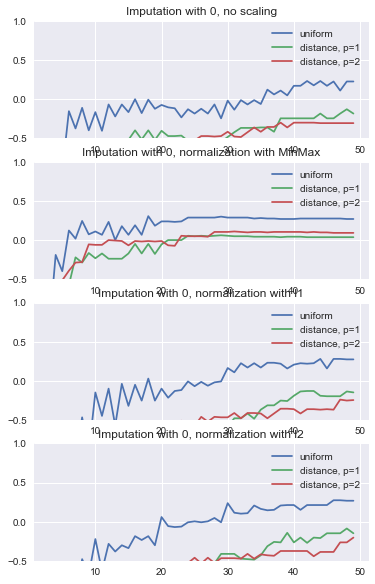

In [4]:
plt.subplots_adjust(top=2)
plt.style.use('seaborn')

# No Scaling
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))
plt.subplot(411)
plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_noScaling", title="Imputation with 0, no scaling")

# MinMax
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))
preprocessed_data = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(preprocessed_data))    # Normalization with l1 norm
plt.subplot(412)
plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_minMax", title="Imputation with 0, normalization with MinMax")

# L1 Norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))    # Normalization with l1 norm
plt.subplot(413)
plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_l1Norm", title="Imputation with 0, normalization with l1")

# L2 Norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l2").fit_transform(preprocessed_data))
plt.subplot(414)
plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_l2Norm", title="Imputation with 0, normalization with l2")
#plt.savefig("out/companies_knn_simpleImputation")
plt.show()

## Mean Imputation

Finished evaluation
Best parameteters found with: {'n_neighbors': 44, 'weights': 'uniform', 'p': 1}
score= 0.2796610169491525
Total evaluation time = 27.11s
Finished evaluation
Best parameteters found with: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}
score= 0.29782082324455206
Total evaluation time = 58.42s
Finished evaluation
Best parameteters found with: {'n_neighbors': 26, 'weights': 'uniform', 'p': 2}
score= 0.30387409200968524
Total evaluation time = 23.61s
Finished evaluation
Best parameteters found with: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}
score= 0.9285714285714286
Total evaluation time = 32.94s


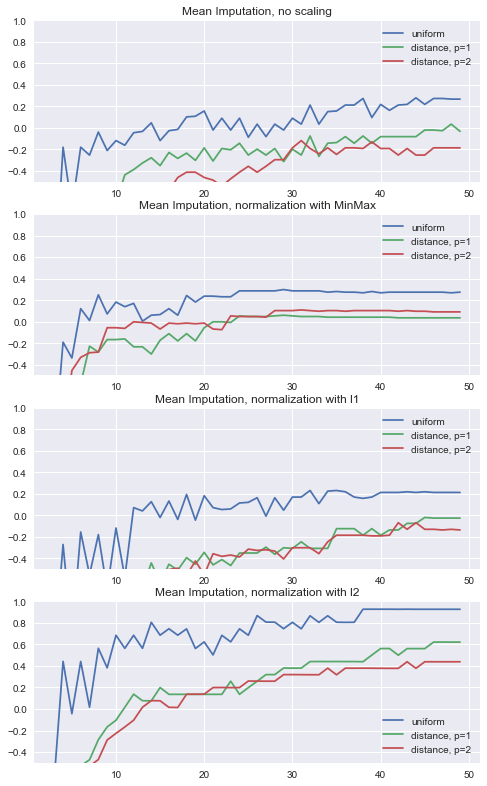

In [5]:
plt.subplots_adjust(top=2)
plt.style.use('seaborn')

# No Scaling
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean").fit_transform(raw_data))
plt.subplot(411)
plot_params(preprocessed_data, labels, fileName="companies_knn_meanIputation_noScaling", title="Mean Imputation, no scaling")

# MinMax
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean", fill_value=0).fit_transform(raw_data))
preprocessed_data = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(preprocessed_data))    # Normalization with l1 norm
plt.subplot(412)
plot_params(preprocessed_data, labels, fileName="companies_knn_meanImputation_minMax", title="Mean Imputation, normalization with MinMax")

# l1 norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean").fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))
plt.subplot(413)
plot_params(preprocessed_data, labels, fileName="companies_knn_meanIputation_l1norm", title="Mean Imputation, normalization with l1")

# l2 norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean").fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l2").fit_transform(preprocessed_data))
plt.subplot(414)
plot_params(preprocessed_data, labels, fileName="companies_knn_meanIputation_l2norm", title="Mean Imputation, normalization with l2")
#plt.savefig("out/companies_knn_meanImputation")
plt.show()

# Runtime Analysis

# Best parameter

In [27]:
# l1 norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean").fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))


x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.3, random_state=1)

model = KNeighborsClassifier(n_neighbors=27, weights="uniform")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

print("Accuracy=", accuracy_score(y_test, y_pred))
print("Score=", companies_data_preprocessor.calculate_score(y_test, y_pred))
print("F1=", f1_score(y_test, y_pred))

print("precisions=", precision_score(y_test, y_pred))
print("Recall=", recall_score(y_test, y_pred))

print(mat)

Accuracy= 0.9351381838691484
Score= 0.9303874092009685
F1= 0.09448818897637795
precisions= 1.0
Recall= 0.049586776859504134
[[1652    0]
 [ 115    6]]
